In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
import chainer

import pickle as pkl
import matplotlib

from torch.autograd import Variable
from torch.nn import RNN, GRU, LSTM, Linear, Embedding
from tqdm import tqdm
from torch import nn
import torch
from keras.utils import to_categorical

import lyapunov as l
from importlib import reload  # Python 3.4+ only.
import gc
import sys
from math import floor
from importlib import reload

from random import random
from random import seed

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
import os.path as path

import dataloader as dl

Using TensorFlow backend.


In [2]:
class Config:
    def __init__(self, data_dir = 'CharRNN/WP', rnn_model = 'lstm', hidden_size = 128, num_layers = 1, dropout = 0.0, learning_rate = .002, embedded = 'one-hot',
                 seq_length = 100, batch_size= 100, max_epochs = 50, decay_rate = 0.95, decay_start = 10, train_frac = 0.8, val_frac = 0.1, cuda = torch.cuda.is_available(), model_dir = '',
                 print_interval = 100, optimizer = 'rms'):
        
        self.data_dir = data_dir 
        
        self.rnn_model = rnn_model
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.embedded = embedded
        
        self.learning_rate = learning_rate #initial learning rate
        self.optimizer = optimizer
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.decay_rate = decay_rate
        self.decay_start = decay_start
        self.train_frac = train_frac
        self.val_frac = val_frac
        
        self.cuda = cuda
        self.model_dir = model_dir
        self.full_name = "{}_L{}_H{}_drop{}_{}".format(self.rnn_model, self.num_layers, self.hidden_size, self.dropout, self.optimizer)
        
        self.print_interval = print_interval

## Data Preprocessing

In [91]:
dl = reload(dl)

In [4]:
con = Config()
train_set, val_set, test_set, (char_to_int, int_to_char) = dl.create_dataset(con)
vocab_size = len(char_to_int)

Loading  CharRNN/WP/data.pkl ...
Loading  CharRNN/WP/vocab.pkl ...
None
Cutting off end of data so that it divides evenly
Data load done! Number of data batches in train: 256, val: 32, test: 31


In [5]:
rnn_sizes = [157, 289, 549]
lstm_sizes = [64, 128, 256, 512]
gru_sizes = [78, 153, 301, 597]

In [5]:
print(vocab_size)

82


## Create Model Template, Train and Validation functions

In [9]:
# build the model using the pytorch nn module
class CharRNN(nn.ModuleList):
    def __init__(self, num_layers, vocab_size, hidden_size, model = 'lstm', p_drop = 0.0, embedded = 'one-hot', dynamics = False, cuda = torch.cuda.is_available()):
        super(CharRNN, self).__init__()
        
        # init the meta parameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.model = model
        self.L = self.num_layers*self.hidden_size
        self.dynamics = dynamics
        self.embedded = embedded
        self.device = torch.device('cuda') if cuda else torch.device('cpu')
        
        if self.embedded == None:
            self.encoder = nn.Identity()
        elif self.embedded == 'embedding':
            self.encoder = Embedding(input_size, input_size)
        elif self.embedded == 'one-hot':
            self.encoder = lambda xt: torch.from_numpy(to_categorical(xt.cpu(), self.vocab_size)).to(self.device)
        else:
            raise Exception('Embedding type not defined')
            
            
        if model == 'rnn':
            self.rnn_layer = RNN(num_layers = self.num_layers, hidden_size=hidden_size, input_size=vocab_size, batch_first=True, bias = False)
            self.gate_size = hidden_size
        elif model == 'gru':
            self.rnn_layer = GRU(num_layers = self.num_layers, hidden_size=hidden_size, input_size=vocab_size, batch_first=True, bias = False)
            self.gate_size = 3*hidden_size
        elif model == 'lstm':
            self.rnn_layer = LSTM(num_layers = self.num_layers, hidden_size=hidden_size, input_size=vocab_size, batch_first=True, bias = False)
            self.gate_size = 4*hidden_size
        else:
            raise Exception('Recurrent model not defined. Exitting.')
        
        #Initialize weights to all be between -0.08 and 0.08 
        for layer_p in self.rnn_layer._all_weights:
            for p in layer_p:
                if 'weight' in p:
                    nn.init.uniform_(self.rnn_layer.__getattr__(p), -0.08, 0.08)
        
        self.dropout = nn.Dropout(p=p_drop)
        self.fc = Linear(in_features = hidden_size, out_features = vocab_size, bias = False)
        
    def forward(self, xt, h):
        encoded = self.encoder(xt)
        self.rnn_layer.flatten_parameters()
        rnn_out, rnn_hn = self.rnn_layer(encoded, h)
        d_out = self.dropout(rnn_out)
        output = self.fc(d_out)
        return output, rnn_hn
    
    
    def init_hidden(self, batch_size):
        if self.model == 'lstm':
            if self.dynamics:
                return (Variable(torch.randn(self.num_layers, batch_size, self.hidden_size)).to(device),
                    Variable(torch.randn(self.num_layers, batch_size, self.hidden_size)).to(device))
            else:
                return (Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device),
                    Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(self.device))

        if self.dynamics:
            return Variable(torch.randn(self.num_layers, batch_size, self.hidden_size)).to(device)
        else:
            return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device)


In [7]:
def train(train_set, val_set, vocab_size, config):
    device = torch.device('cuda') if config.cuda else torch.device('cpu')
    char_rnn = CharRNN(vocab_size = vocab_size, num_layers= config.num_layers, hidden_size = config.hidden_size, model = config.rnn_model, p_drop = config.dropout, embedded = config.embedded).to(device)
    
    # train_input_set : (train_batches, batch_size, seq_length); the rest are similar
    train_input_set, train_target_set = train_set[0], train_set[1]
    val_input_set, val_target_set = val_set[0], val_set[1]
    
    criterion = nn.CrossEntropyLoss()   # include softmax
    if config.optimizer == 'rms':
        optimizer = torch.optim.RMSprop(params = char_rnn.parameters(), lr = config.learning_rate)
    elif config.optimizer == 'adam':
        optimizer = torch.optim.Adam(params = char_rnn.parameters(), lr = config.learning_rate)
    else:
        print(config.optimizer +'is not a recognized optimizer')
        return
    # learning rate decay
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = range(config.decay_start, config.max_epochs+1) , gamma = config.decay_rate)
    
    best_val_loss = sys.float_info.max
    
    train_losses = []
    torch.save(char_rnn.state_dict(), path.join(config.model_dir, "Models/{}_e0.pth".format(config.full_name)))
    for epoch_idx in tqdm(range(1, config.max_epochs + 1)): # for evary epoch
#             print("Training for %d epochs..." % epoch_idx)
        running_loss = 0.0
    
    # initialize hidden states for every epoch
        hidden = char_rnn.init_hidden(config.batch_size)  # (n_layers * n_directions, batch_size, hidden_size)
        # ship to gpu if possible
        if torch.cuda.is_available() and config.cuda:
            if config.rnn_model == 'lstm':
                hidden = tuple([x.cuda() for x in hidden])
            else:
                hidden = hidden.cuda()
        
        for batch_idx in range(1, train_input_set.shape[0] + 1):   # for every batch
            # for every batch
            optimizer.zero_grad()   # zero the parameter gradients

            train_input = train_input_set[batch_idx - 1]

            # ship to gpu if possible
            if torch.cuda.is_available() and config.cuda:
                train_input = train_input.cuda()
            
            xt = Variable(train_input)
            # compute loss for this batch
            loss = 0
#                 for i in range(config.seq_length):  # for every time step in this batch
            # forward pass
            train_output, hidden = char_rnn(xt, hidden) # ignore gate values
            # add up loss at each time step
            loss += criterion(train_output.view(-1, vocab_size), Variable(train_target_set[batch_idx-1].view(config.seq_length*config.batch_size)).to(device))
#             loss += criterion(train_output.view(config.batch_size, -1).cpu(),
#                               Variable(train_target_set[batch_idx - 1]))

#             detach hidden state from current computational graph for back-prop
            if config.rnn_model == 'lstm':
                for x in hidden:
                    x.detach_()
            else:
                hidden.detach_()

            # backward
            loss.backward()
            optimizer.step()
            

            # print statistics
            running_loss += loss.item()
#             if batch_idx % config.print_interval == 0:  # print_interval batches
#                 print('[%d, %4d] loss: %.3f' % (epoch_idx, batch_idx, running_loss / config.print_interval))
#                 running_loss = 0.0

            '''
            # validate model
            val_loss = 0
            # for every batch
            for val_batch_idx in range(1, val_input_set.shape[0] + 1):
                val_input = val_input_set[val_batch_idx - 1]
                # ship to gpu if possible
                if torch.cuda.is_available() and config.cuda:
                    val_input = val_input.cuda()
                for i in range(config.seq_length):  # for every time step in this batch
                    # forward pass
                    val_output, _, _ = char_rnn(Variable(val_input[:, i]), hidden)
                    # add up loss at each time step
                    val_loss += criterion(val_output.view(config.batch_size, -1).cpu(),
                                          Variable(val_target_set[val_batch_idx - 1][:, i]))
            val_loss /= val_input_set.shape[0]  # loss per batch
            print('Validation loss: %.3f' % val_loss)
            # save the best model sofar
            if val_loss.data[0] < best_val_loss:
                print('Saving model [%d, %4d]...' % (epoch_idx, batch_idx))
                torch.save(char_rnn.state_dict(), path.join(config.model_dir, config.model + '.pth'))
                # to load a saved model: char_rnn = CharRNN(*args, **kwargs), char_rnn.load_state_dict(torch.load(PATH))
                best_val_loss = val_loss.data[0]
            '''

        train_losses.append(running_loss/(train_input_set.shape[0] + 1))
#         print('Epoch %d Training Loss: %4f' % (epoch_idx, train_losses[epoch_idx-1]))
        scheduler.step()    # lr decay
        # save model after each epoch
        torch.save(char_rnn.state_dict(), path.join(config.model_dir, "Models/"+ config.full_name +"_e{}.pth".format(epoch_idx)))
    pkl.dump(train_losses, open(path.join(config.model_dir, config.full_name+"_trainLoss.p".format(config.dropout)), 'wb'))

In [8]:
def val(config, val_set, vocab_size):
    criterion = nn.CrossEntropyLoss()   # include softmax
    if torch.cuda.is_available() and config.cuda:
        device = torch.device('cuda')
    val_losses = []
    val_input_set, val_target_set = val_set[0], val_set[1]
    for epoch in tqdm(range(config.max_epochs)):
        char_rnn = CharRNN(config.num_layers, vocab_size, config.hidden_size, model=config.rnn_model, p_drop = config.dropout, embedded = config.embedded).to(device)
        char_rnn.load_state_dict(torch.load(path.join(config.model_dir, "Models/" + config.full_name)+'_e{}.pth'.format(epoch)))
        running_loss = 0.0

        hidden = char_rnn.init_hidden(config.batch_size)  # (n_layers * n_directions, batch_size, hidden_size)
        # ship to gpu if possible
        if torch.cuda.is_available() and config.cuda:
            if config.rnn_model == 'lstm':
                hidden = tuple([x.cuda() for x in hidden])
            else:
                hidden = hidden.cuda()

        for batch_idx in range(1, val_input_set.shape[0] + 1):   # for every batch
            # for every batch
            val_input = val_input_set[batch_idx - 1]

            # ship to gpu if possible
            if torch.cuda.is_available() and config.cuda:
                val_input = val_input.cuda()

            xt = Variable(val_input)
            # compute loss for this batch
            loss = 0
            val_output, hidden = char_rnn(xt, hidden)
            # add up loss at each time step
            loss += criterion(val_output.view(-1, vocab_size), Variable(val_target_set[batch_idx-1].view(config.seq_length*config.batch_size)).to(device))
            running_loss += loss.item()
        val_losses.append(running_loss/(val_input_set.shape[0] + 1))
    pkl.dump(val_losses, open(path.join(config.model_dir, config.full_name+"_valLossFull.p"), 'wb'))
    return val_losses

## Train Models

In [12]:
dropout = 0.2
optimizer  = 'adam'

In [72]:
print(dos)

[0.11, 0.48, 0.06, 0.35, 0.04, 0.12, 0.5, 0.1, 0.32, 0.23]


In [9]:
dos = pkl.load(open('CharRNN/WP/dropouts.p', 'rb'))

In [ ]:
optim = 'adam'
for dropout in dos:
    for size in rnn_sizes:
        config = Config(model_dir = 'CharRNN/WP', dropout = dropout, max_epochs = 50, decay_rate = .95, hidden_size = size, optimizer  = optim, rnn_model = 'rnn')
        pkl.dump(config, open(path.join(config.model_dir, config.full_name + '_train_config.p'), 'wb'))
        train(train_set, val_set, vocab_size, config)

In [ ]:
optimizer  = 'adam'
for size in gru_sizes:
    for dropout in [0.04, 0.06]:
        config = Config(model_dir = 'CharRNN/WP', dropout = dropout, max_epochs = 50, decay_rate = .95, hidden_size = size, optimizer  = optimizer, rnn_model = 'gru')
        pkl.dump(config, open(path.join(config.model_dir, config.full_name + '_trainConfig.p'), 'wb'))
        train(train_set, val_set, vocab_size, config)

 28%|██▊       | 14/50 [05:11<13:20, 22.24s/it]

In [68]:
optimizer  = 'adam'
for size in lstm_sizes:
    for dropout in dos:
        config = Config(model_dir = 'CharRNN/WP', dropout = dropout, max_epochs = 50, decay_rate = .95, hidden_size = size, rnn_model = 'lstm', optimizer = optimizer)
        pkl.dump(config, open(path.join(config.model_dir, config.full_name + '_trainConfig.p'), 'wb'))
        train(train_set, val_set, vocab_size, config)

100%|██████████| 50/50 [16:27<00:00, 19.74s/it]


## Validation

In [10]:
dos = pkl.load(open('CharRNN/WP/dropouts.p', 'rb'))

In [69]:
model = 'lstm'
optim = 'adam'
for size in lstm_sizes:
    for dropout in dos:
        con = pkl.load(open('CharRNN/WP/{}_L1_H{}_drop{}_{}_trainConfig.p'.format(model, size, dropout, optim), 'rb'))
        val(con, val_set, vocab_size)

100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


In [ ]:
model = 'rnn'
for size in rnn_sizes:
    con = pkl.load(open('CharRNN/WP/{}_L1_H{}_trainConfig.p'.format(model, size), 'rb'))
    val(con, val_set, vocab_size)

#

In [18]:
def plot_train_losses(rnn_model, dropout, optim):
    if rnn_model == 'rnn':
        sizes = rnn_sizes
    elif rnn_model == 'gru':
        sizes = gru_sizes
    elif rnn_model == 'lstm':
        sizes = lstm_sizes
    else:
        print('Invalid RNN model')
        return None
    l = len(sizes)
    tl= np.zeros((0, 50))
    for i in range(l):
        con = Config(model_dir = 'CharRNN/WP', max_epochs = 50, dropout = dropout, hidden_size = sizes[i], rnn_model = rnn_model, optimizer = optim)
        tnew = np.array([pkl.load(open(con.model_dir +"/"+con.full_name+"_trainLoss.p", 'rb'))])
        tl = np.concatenate((tl, tnew), axis = 0) 
        plt.plot(tl[i])
    plt.title('Train Losses for {}'.format(con.full_name))
    plt.legend(sizes)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    return tl

In [8]:
def plot_val_losses(rnn_model, dropout, optim):
    if rnn_model == 'rnn':
        sizes = rnn_sizes
    elif rnn_model == 'gru':
        sizes = gru_sizes
    elif rnn_model == 'lstm':
        sizes = lstm_sizes
    else:
        print('Invalid RNN model')
        return None
    l = len(sizes)
    vl= np.zeros((0, 50))
    for i in range(l):
        con = Config(model_dir = 'CharRNN/WP', max_epochs = 50, hidden_size = sizes[i], rnn_model = rnn_model, dropout = dropout, optimizer = optim)
        tnew = np.array([pkl.load(open(con.model_dir + "/{}_valLoss.p".format(con.full_name), 'rb'))])
        vl = np.concatenate((vl, tnew), axis = 0) 
        plt.plot(vl[i])
    plt.title('Validation Losses for {}'.format(con.full_name))
    plt.legend(sizes)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    return vl

(1.2, 1.7)

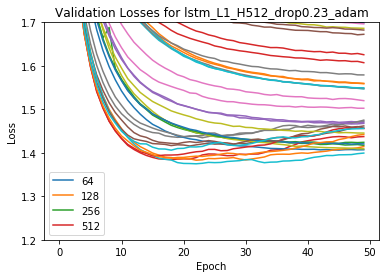

In [20]:
# d = dos[2]
# v = plot_val_losses('gru', d, 'adam')
v_min = []
v_final = []
for d in dos:
    v = plot_val_losses('lstm', d, 'adam')
    v_min.append(np.min(v))
    v_final.append(v[-1, -1])
# v2 = plot_val_losses('gru', 0.2, 'adam')
# plt.plot((v-v2).T)
# t = plot_train_losses('gru', 0.2, 'adam')
# t2 = plot_train_losses('lstm', 0.2, 'adam')
# plt.xlim([8, 50])
plt.ylim([1.2, 1.7])

(1.2, 1.5)

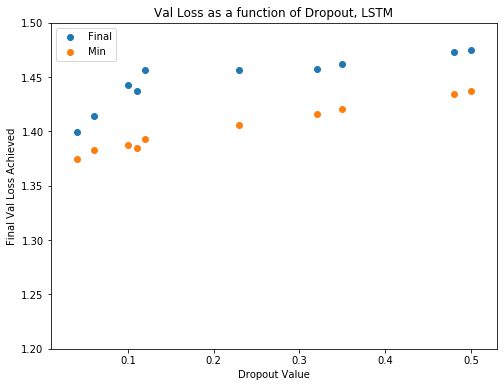

In [21]:
f = plt.figure(figsize = (8, 6))
plt.scatter(dos, v_final, label = 'Final')
plt.scatter(dos, v_min, label = 'Min')
plt.xlabel('Dropout Value')
plt.ylabel('Final Val Loss Achieved')
plt.title('Val Loss as a function of Dropout, LSTM')
plt.legend()
plt.ylim([1.2, 1.5])

In [56]:
dos

[0.11, 0.48, 0.06, 0.35, 0.04, 0.12, 0.5, 0.1, 0.32, 0.23]

In [35]:
print(min(v[3]))
print(min(v2[3]))

1.428942539475181
1.4041881489031243


(-0.1, 0.6)

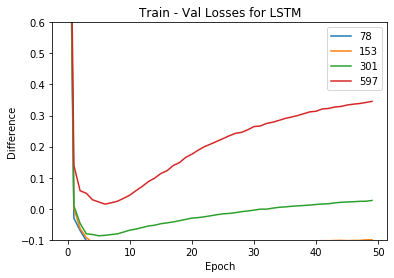

In [65]:
plt.plot(range(50), (v-t).T)
plt.title('Train - Val Losses for LSTM')
plt.legend(gru_sizes)
plt.xlabel('Epoch')
plt.ylabel('Difference')
plt.ylim([-.1, .6])

## LE Calculation

In [79]:
import math
# l  =reload(l)

model = 'lstm'
optims = ['adam']
i1 = list(range(5))
i2 = list(range(0, 13, 2))
i3 = [50]
samples = i3
dropouts = [0.06, 0.23, 0.35]
for dropout in dropouts:
    for optim in ['adam']:
        for size in [lstm_sizes[3]]:
            con = Config(model_dir = 'CharRNN/WP', dropout = dropout, max_epochs = 50, batch_size = 25, decay_rate = .95, hidden_size = size, seq_length = 250, rnn_model = model, optimizer = optim)
            test_input_set, test_target_set = test_set[0], test_set[1]

            LE_means = []
            LE_stds = []
            rval_list = []
            batch_size, seq_length = con.batch_size, con.seq_length
            xt_flat = torch.flatten(test_input_set)[:batch_size * seq_length * math.floor(test_input_set.nelement() / (batch_size * seq_length))]
            idx = torch.randperm(xt_flat.nelement())
            test_dr = torch.from_numpy(to_categorical(xt_flat[idx].view(-1, batch_size, seq_length), vocab_size)).to(device)
            i = torch.randint(low = 0, high = test_dr.shape[0], size =  (1,)).item()


            for epoch in samples:
                net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)
                net.load_state_dict(torch.load(path.join(con.model_dir, "Models/" + con.full_name)+'_e{}.pth'.format(epoch)))
                h_l = net.init_hidden(con.batch_size)
                LE_char, rvals_char = l.calc_LEs_an(test_dr[i], h_l, model = net, k_LE = 10000, rec_layer = con.rnn_model)
                
                LE_mean, LE_std = l.LE_stats(LE_char)
                rval_list.append(rvals_char)
                LE_means.append(LE_mean)
                LE_stds.append(LE_std)
                if (epoch+1)%10 == 0:
                    pkl.dump((LE_means, LE_stds), open(path.join(con.model_dir, con.full_name + 'LEstats_e{}'.format(epoch)), 'wb'))
            pkl.dump(rval_list,  open(path.join(con.model_dir, con.full_name + '_rvals_e50.p'), 'wb'))
            pkl.dump((LE_means, LE_stds), open(path.join(con.model_dir, con.full_name + '_LEstats_e50.p'), 'wb'))


100%|██████████| 250/250 [15:12<00:00,  3.65s/it]

 67%|██████▋   | 167/250 [10:15<05:05,  3.68s/it]

100%|██████████| 250/250 [15:20<00:00,  3.68s/it]

100%|██████████| 250/250 [15:16<00:00,  3.66s/it]


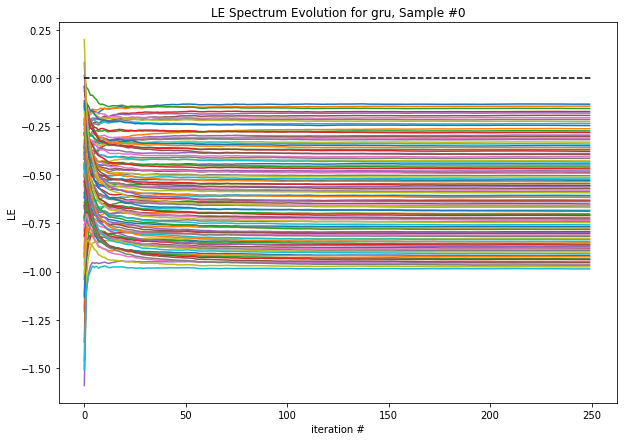

In [71]:
l.plot_evolution(torch.Tensor(np.expand_dims(torch.mean(rvals_char[:, :, :], dim = 0), 0)), k_LE = 100, model_name = 'gru', sample_id = 0)
plt.plot([0, 250], [0, 0], 'k--')

In [45]:
torch.Tensor(np.expand_dims(torch.mean(rvals_char[:, :, :], dim = 0), 0))[0]

tensor([[1.0421e+00, 1.3918e+00, 1.1460e+00,  ..., 6.4216e-02, 4.9703e-02,
         3.8081e-02],
        [1.4029e+00, 1.3389e+00, 1.3428e+00,  ..., 4.8190e-02, 3.9228e-02,
         2.5282e-02],
        [1.3385e+00, 1.3360e+00, 1.3320e+00,  ..., 2.4526e-02, 1.8797e-02,
         8.7321e-03],
        ...,
        [9.9146e-01, 9.6290e-01, 9.7960e-01,  ..., 1.5751e-04, 9.3803e-05,
         6.6777e-05],
        [9.8542e-01, 9.8073e-01, 9.8936e-01,  ..., 1.8471e-04, 1.0613e-04,
         5.1593e-05],
        [9.9584e-01, 1.0052e+00, 9.9622e-01,  ..., 1.5176e-04, 9.3797e-05,
         4.4004e-05]])

tensor([1.0421, 1.4029, 1.3385, 1.2696, 1.0926, 1.0465, 1.0112, 0.9814, 1.0003,
        0.9923, 0.9900, 1.0012, 1.0290, 1.0620, 1.0066, 1.0252, 0.9849, 0.9809,
        1.0516, 1.0135, 1.0108, 1.0092, 1.0333, 1.0260, 0.9986, 0.9908, 1.0471,
        1.0652, 1.0984, 1.0815, 0.9890, 0.9945, 1.0277, 1.0349, 1.0071, 1.0077,
        1.0041, 1.0031, 0.9915, 0.9780, 1.0007, 1.0031, 1.0088, 1.0028, 1.0193,
        0.9853, 0.9787, 0.9864, 1.0000, 1.0380, 1.0064, 0.9913, 0.9958, 1.0004,
        0.9898, 0.9926, 1.0192, 1.0145, 1.0340, 1.0007, 1.0256, 1.0176, 1.0341,
        1.0301, 0.9733, 0.9649, 0.9977, 1.0198, 1.0033, 1.0046, 1.0262, 1.0089,
        0.9570, 1.0236, 1.0467, 1.0065, 1.0029, 1.0320, 1.0338, 1.0269, 1.0225,
        1.0619, 1.0335, 1.0244, 1.0273, 1.0398, 0.9833, 0.9778, 1.0157, 0.9681,
        1.0042, 1.0271, 0.9958, 0.9924, 0.9697, 0.9875, 1.0300, 0.9831, 1.0307,
        0.9838, 1.0037, 1.0324, 1.0007, 0.9798, 0.9828, 0.9959, 0.9971, 1.0358,
        1.0782, 1.0507, 0.9675, 1.0066, 

In [36]:
optim = 'adam'
for dropout in [.04, .2]:
    for model in ['gru', 'lstm']:
        if model == 'gru':
            sizes = gru_sizes
        elif model == 'lstm':
            sizes = lstm_sizes
        size = sizes[3]
        con = Config(model_dir = 'CharRNN/WP', dropout = dropout, max_epochs = 50, batch_size = 25, decay_rate = .95, hidden_size = size, seq_length = 250, rnn_model = model, optimizer = optim)
        LE_50 = pkl.load(open(path.join(con.model_dir, con.full_name + '_LEstats_e50.p'), 'rb'))
        LE_base, _LE_base = pkl.load(open(path.join(con.model_dir, con.full_name + '_LEstats.p'), 'rb'))
        LE_meansnew = LE_base[0].append(LE_50[0])
        LE_stdsnew = LE_stds[1].append(LE_50[1])

EOFError: Ran out of input

In [27]:
test = pkl.load(open(path.join(con.model_dir, con.full_name + '_LEstats_e50.p'), 'rb'))

EOFError: Ran out of input

In [35]:
pkl.load(open(path.join(con.model_dir, con.full_name + '_LEstats_e50.p'), 'rb'))

EOFError: Ran out of input

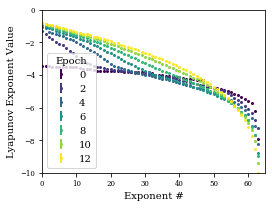

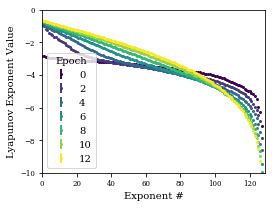

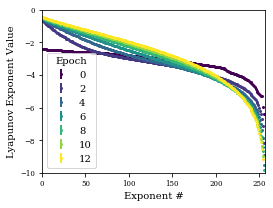

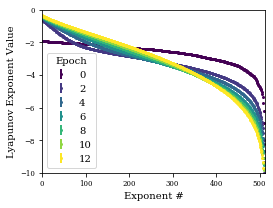

In [16]:
# for size in rnn_sizes:
# for size in [78, 153, 301, 597]: #For GRU
dropout = 0.2
optim = 'adam'
model = 'lstm'
# for size in [64, 128, 256, 512]: # For LSTM
for size in lstm_sizes:
    con = Config(model_dir = 'CharRNN/WP', dropout = dropout, max_epochs = 50, batch_size = 25, decay_rate = .95, hidden_size =size, seq_length = 250, rnn_model = model, optimizer = optim)
    (LE_means, LE_stds) = pkl.load(open(path.join(con.model_dir, con.full_name +'_LEstats.p'), 'rb'))
#     i1 = list(range(5))
    i2 = list(range(0, 13, 2))
    i3 = [50]
    samples = i2

    k_LE = min(con.hidden_size*con.num_layers, 100000)
    gradient = np.linspace(0, 1, max(samples)+1)
    cmap = matplotlib.cm.get_cmap('viridis')
    hidden_size = con.hidden_size
    num_layers = con.num_layers
    plt.rc('font', family = 'serif')
    plt.rc('xtick', labelsize = 'x-small')
    plt.rc('ytick', labelsize = 'x-small')
    f = plt.figure(figsize = (4, 3))
    for i, (LE_mean, LE_std) in enumerate(zip(LE_means, LE_stds)):
        rgba = cmap(gradient[samples[i]])
        x = np.linspace(0, k_LE-1, k_LE)
        if i >=0: #and (samples[i] % 10 == 0):
            for j in range(num_layers):
                label = str(samples[i])
                f = plt.errorbar(x+j*k_LE, LE_mean[j*hidden_size:k_LE+j*hidden_size].to(torch.device('cpu')), yerr=0*LE_mean[:k_LE].to(torch.device('cpu')), c = rgba, marker = '.', linestyle = ' ', markersize = 4, elinewidth = 2, label = label, )#'epoch {}'.format(i) if (j==0 and epoch%2 == 0) else None)
#                 f = plt.loglog(x+j*k_LE, torch.abs(LE_mean[j*hidden_size:k_LE+j*hidden_size].to(torch.device('cpu'))), c = rgba, marker = '.', linestyle = ' ', markersize = 6.5, label = label)
    plt.xlabel('Exponent #')
    plt.xlim([0, k_LE+1])
    plt.ylim([-10, 0])
    plt.ylabel('Lyapunov Exponent Value')
#     plt.plot([0,num_layers*k_LE], [0,0], 'k--')
#     plt.title('Mean Lyapunov Exponent Spectrum for ' + con.rnn_model + ' on WP \n Layers: {}, Hidden Size: {}, Optimizer: {}'.format(num_layers, hidden_size, con.optimizer))
    plt.legend(title = 'Epoch', loc = 3);
    plt.savefig(fname = con.model_dir + '/' + con.full_name+ '_LEspectrum.png', bbox_inches="tight",dpi=400, format = 'png')

In [55]:
seed(8)
dos = [round(random()/2,2) for _ in range(10)]
print(dos)
pkl.dump(dos, open('CharRNN/WP/dropouts.p', 'wb'))

[0.11, 0.48, 0.06, 0.35, 0.04, 0.12, 0.5, 0.1, 0.32, 0.23]


# Optimize over LE Slope

In [10]:
def best_fit_slope(x,y):
#     m = np.mean(ys)
    xs = torch.Tensor(x)
    ys = torch.Tensor(y)
    m = (((torch.mean(xs)*torch.mean(ys)) - torch.mean(xs*ys)) /
         ((torch.mean(xs)**2) - torch.mean(xs**2)))
    return m

In [20]:
optim_epochs = 4
optim_seq_len = 100
dropout = .2
size = 512
model = 'lstm'
optim = 'adam'

test_input_set, test_target_set = test_set[0], test_set[1]
con = Config(model_dir = 'CharRNN/WP', dropout = dropout, max_epochs = optim_epochs, batch_size = 25, decay_rate = .95, hidden_size = size, seq_length = optim_seq_len, rnn_model = model, optimizer = optim)
net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)



In [21]:
import math
def le_loss(net, con):

    batch_size, seq_length = con.batch_size, con.seq_length
    xt_flat = torch.flatten(test_input_set)[:batch_size * seq_length * math.floor(test_input_set.nelement() / (batch_size * seq_length))]
    idx = torch.randperm(xt_flat.nelement())
    test_dr = torch.from_numpy(to_categorical(xt_flat[idx].view(-1, batch_size, seq_length), vocab_size)).to(device)
    i = torch.randint(low = 0, high = test_dr.shape[0], size =  (1,)).item()


    # net.load_state_dict(torch.load(path.join(con.model_dir, "Models/" + con.full_name)+'_e{}.pth'.format(epoch)))
    h_l = net.init_hidden(con.batch_size)
    LE_char, _ = l.calc_LEs_an(test_dr[i], h_l, model = net, k_LE = 10000, rec_layer = con.rnn_model)
    
    LE_mean, _ = l.LE_stats(LE_char)
    slopes = best_fit_slope(np.array(range(slope_inds[0], slope_inds[1])), np.array(LE_mean[slope_inds[0]:slope_inds[1]]))
    return slopes

In [22]:
le_loss(net, con)


 42%|████▏     | 42/100 [02:30<03:29,  3.60s/it]

KeyboardInterrupt: 